In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix


%matplotlib inline

In [2]:
tops=pd.read_csv(r'D:\jonahfull.csv')
small=tops.head()

In [11]:
tops.ssdepth = tops.ssdepth+11183

In [15]:
tops.head()

,api,formation,depth,ssdepth,normd
0,3521913,WASATCH,0,18464,0
1,3521913,LANCE,9285,9179,-4.633233533
2,3521913,LANCE - OVER PRESSURE,9760,8704,-3.9370714
3,3521913,JONAH,11227,7237,-2.845159655
4,3521913,YELLOW POINT,11793,6671,-2.613696809


In [16]:
data=np.asarray(tops[['api', 'formation', 'ssdepth']])
tops['depth'].max()

18245

In [17]:
D_df = tops.pivot_table('ssdepth', 'formation', 'api').fillna(0)

In [18]:
R =D_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [19]:
n_wells = tops.api.unique().shape[0]
n_formations = tops.formation.unique().shape[0]

print('Number of wells: {}'.format(n_wells))
print('Number of formations: {}'.format(n_formations))
print('Sparsity: {:4.3f}%'.format(float(tops.shape[0]) / float(n_wells*n_formations) * 100))

Number of wells: 2861
Number of formations: 442
Sparsity: 1.180%


In [7]:
formation_to_idx = {}
idx_to_formation = {}
for (idx, formation) in enumerate(tops.formation.unique().tolist()):
    formation_to_idx[formation] = idx
    idx_to_formation[idx] = formation
    
api_to_idx = {}
idx_to_api = {}
for (idx, api) in enumerate(tops.api.unique().tolist()):
    api_to_idx[api] = idx
    idx_to_api[idx] = api

In [8]:
def map_ids(row, mapper):
    return mapper[row]
import scipy.sparse as sparse


In [9]:
#%%timeit
J = tops.api.apply(map_ids, args=[api_to_idx]).as_matrix()
I = tops.formation.apply(map_ids, args=[formation_to_idx]).as_matrix()
V = tops.depth.astype(int)#/max(tops.depth.astype(int))
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

In [20]:
print('Number of data points: {}'.format(n_wells*n_formations))

Number of data points: 1264562


In [21]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 10)
sigma = np.diag(sigma)


In [22]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = D_df.columns, index=D_df.index)

In [23]:
preds_df.iloc[0:,1]

formation
1ST LANCE SS               7.986716
1ST OVERPRESSURE         -13.697508
2ND OVERPRESSURE          -7.171816
;AMCE ;PWER A              0.971351
;AMCE LOWER D              0.151576
ALMOND                    14.669708
ASPEN                     11.832533
B ASE FORT UNION           6.685460
BACON RIDGE                5.901388
BASAL FT. UNION COAL      17.125739
BASE ARKOSE                6.077803
BASE FORT UNION          239.828152
BASE FT. UNION            11.276122
BASE OF JONAH             -6.357868
BASEL FORT UNION          -0.711980
BAXTER                     1.942572
BENCH                      2.179494
BIOS                     289.434408
BIOS MARKER               88.799859
BLAIR                     33.398698
BOIS                     544.648287
BOIS MARK               1308.819068
BOIS MARKER              143.742376
BOISK                      5.155454
BOISMK                    37.265058
BOSIMK                    14.251502
BOUNDARY                  23.840501
COR COAL 2        

In [24]:
D_df.iloc[0:,1]

formation
1ST LANCE SS               0.0
1ST OVERPRESSURE           0.0
2ND OVERPRESSURE           0.0
;AMCE ;PWER A              0.0
;AMCE LOWER D              0.0
ALMOND                     0.0
ASPEN                      0.0
B ASE FORT UNION           0.0
BACON RIDGE             2837.0
BASAL FT. UNION COAL       0.0
BASE ARKOSE                0.0
BASE FORT UNION            0.0
BASE FT. UNION             0.0
BASE OF JONAH              0.0
BASEL FORT UNION           0.0
BAXTER                     0.0
BENCH                      0.0
BIOS                       0.0
BIOS MARKER                0.0
BLAIR                      0.0
BOIS                       0.0
BOIS MARK                  0.0
BOIS MARKER                0.0
BOISK                      0.0
BOISMK                     0.0
BOSIMK                     0.0
BOUNDARY                   0.0
COR COAL 2                 0.0
DAKOTA                     0.0
DAKOTA "B"                 0.0
                         ...  
WASATCH COAL               0.

In [32]:
import implicit

In [150]:
model = implicit.als.AlternatingLeastSquares(factors=30)

In [151]:
model.fit(likes)

In [152]:
user_items = likes.T.tocsr()

In [153]:
recommendations = model.recommend(0, user_items)

In [154]:
likes

<442x2861 sparse matrix of type '<class 'numpy.float64'>'
	with 14804 stored elements in Compressed Sparse Row format>

In [155]:
recommendations

[(57, 0.8961089),
 (10, 0.8462074),
 (9, 0.83976054),
 (8, 0.79854),
 (22, 0.79053617),
 (244, 0.65557694),
 (11, 0.64325),
 (119, 0.63639545),
 (36, 0.5614818),
 (120, 0.55520636)]

In [147]:
likes.T.tocsr().todense()[0]
np.mean([9285.,  9760., 11227., 11793., 12139., 12477.])

11113.5

In [127]:
tops[tops['api']==3521913]

,api,formation,depth,ssdepth
0,3521913,WASATCH,0,7281
1,3521913,LANCE,9285,-2004
2,3521913,JONAH,11227,-3946
3,3521913,YELLOWPOINT,11793,-4512
4,3521913,WARDELL,12139,-4858
5,3521913,MESAVERDE,12477,-5196


In [159]:
tops.formation.unique()[22]

'TD'

In [169]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
  

In [170]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [172]:
MF_ALS = ExplicitMF(likes, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]


In [25]:
from sklearn.preprocessing import binarize
A=binarize(R)

In [26]:
def runALS(A, R, n_factors, n_iterations, lambda_):
    '''
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    '''
    print("Initiating ")
    lambda_ = 0.1; n_factors = 3; n, m = A.shape; n_iterations = 20
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(np.dot(Items, np.dot(np.diag(Ri), Items.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(Items, np.dot(np.diag(Ri), A[i].T))).T
        print("Error after solving for User Matrix:", get_error(A, Users, Items, R))

        for j, Rj in enumerate(R.T):
            Items[:,j] = np.linalg.solve(np.dot(Users.T, np.dot(np.diag(Rj), Users)) + lambda_ * np.eye(n_factors),
                                     np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])))
        print("Error after solving for Item Matrix:", get_error(A, Users, Items, R))

        MSE_List.append(get_error(A, Users, Items, R))
        print('%sth iteration is complete...' % iter)

    print(MSE_List)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    plt.savefig('Python MSE Graph.pdf', format='pdf')
    plt.show()

Initiating 
Starting Iterations
Error after solving for User Matrix: 9609913.256833237
Error after solving for Item Matrix: 596003.8467435068
0th iteration is complete...
Error after solving for User Matrix: 509030.4523434618
Error after solving for Item Matrix: 439676.5108772813
1th iteration is complete...
Error after solving for User Matrix: 406658.17623910593
Error after solving for Item Matrix: 359080.1913637065
2th iteration is complete...
Error after solving for User Matrix: 327940.09167683346
Error after solving for Item Matrix: 297039.59926865785
3th iteration is complete...
Error after solving for User Matrix: 284588.5656943348
Error after solving for Item Matrix: 275508.98829352064
4th iteration is complete...
Error after solving for User Matrix: 269473.1161429521
Error after solving for Item Matrix: 264136.8674432837
5th iteration is complete...
Error after solving for User Matrix: 259819.31901913797
Error after solving for Item Matrix: 255530.60024506893
6th iteration is c

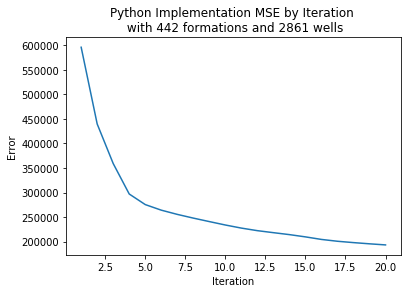

In [30]:
runALS(R, A, 10, 100, 0.1)